# MNIST EDA

## setup

In [4]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import transforms, datasets

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import random
import time

from collections import Counter
from tqdm import tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
CRT_GREEN_BRIGHTEST = '#00FF00'
CRT_GREEN_BRIGHT = '#00DD00'
CRT_GREEN_MEDIUM = '#00AA00'
CRT_GREEN_DIM = '#007700'
CRT_GREEN_DARK = '#004400'
CRT_BG = '#1a1a1a'

plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = CRT_BG
plt.rcParams['axes.facecolor'] = CRT_BG
plt.rcParams['text.color'] = CRT_GREEN_BRIGHT
plt.rcParams['axes.labelcolor'] = CRT_GREEN_BRIGHT
plt.rcParams['axes.edgecolor'] = CRT_GREEN_DIM
plt.rcParams['xtick.color'] = CRT_GREEN_MEDIUM
plt.rcParams['ytick.color'] = CRT_GREEN_MEDIUM
plt.rcParams['grid.color'] = CRT_GREEN_DARK
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10

## data

In [7]:
data = MNIST(root='../data/', download=True, transform=ToTensor())
test_ds = MNIST(root='../data', train=False, transform=ToTensor())

In [8]:
print(f"number of training images: {len(data)}")
print(f"number of test images: {len(test_ds)}")

number of training images: 60000
number of test images: 10000


In [9]:
image, label = data[0]

print(f"\nfirst image shape: {image.shape}")
print(f"first image label: {label}")
print(f"image data type: {image.dtype}")
print(f"min pixel value: {image.min()}")
print(f"max pixel value: {image.max()}")


first image shape: torch.Size([1, 28, 28])
first image label: 5
image data type: torch.float32
min pixel value: 0.0
max pixel value: 1.0


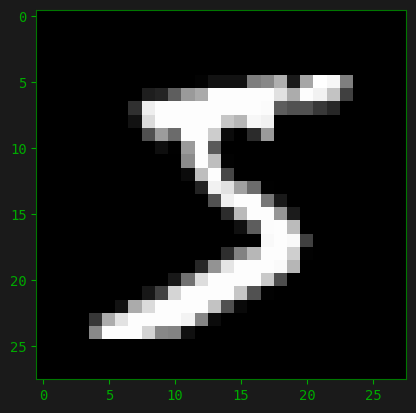

In [10]:
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## EDA

#### class distribution analysis

In [12]:
# Get all labels
labels = [label for image, label in data]
label_counts = Counter(labels)

# Print results
print("=" * 50)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 50)
for digit in range(10):
    count = label_counts[digit]
    percentage = (count / len(data)) * 100
    bar = '█' * int(percentage)
    print(f"Digit {digit}: {count:>5} ({percentage:>5.2f}%) {bar}")
print("=" * 50)

CLASS DISTRIBUTION ANALYSIS
Digit 0:  5923 ( 9.87%) █████████
Digit 1:  6742 (11.24%) ███████████
Digit 2:  5958 ( 9.93%) █████████
Digit 3:  6131 (10.22%) ██████████
Digit 4:  5842 ( 9.74%) █████████
Digit 5:  5421 ( 9.04%) █████████
Digit 6:  5918 ( 9.86%) █████████
Digit 7:  6265 (10.44%) ██████████
Digit 8:  5851 ( 9.75%) █████████
Digit 9:  5949 ( 9.92%) █████████


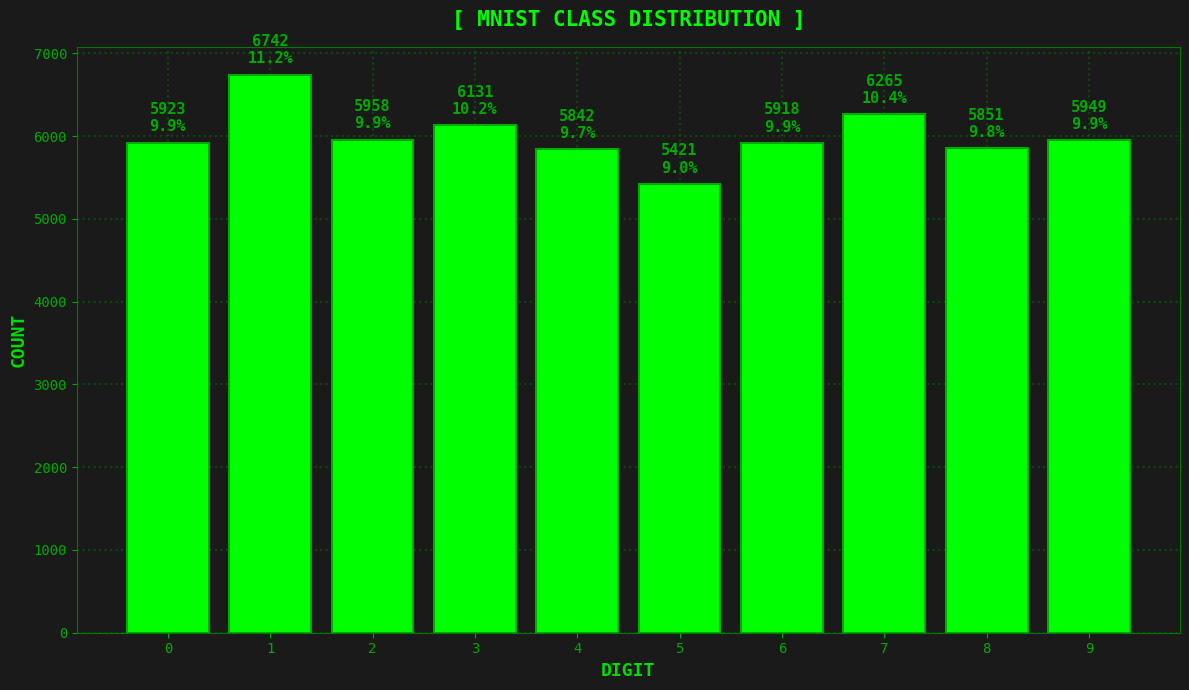

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
digits = list(range(10))
counts = [label_counts[i] for i in digits]

bars = ax.bar(digits, counts, color=CRT_GREEN_BRIGHTEST, edgecolor=CRT_GREEN_MEDIUM, linewidth=1.5)

ax.set_title('[ MNIST CLASS DISTRIBUTION ]', fontsize=15, weight='bold', pad=15, color=CRT_GREEN_BRIGHTEST)
ax.set_xlabel('DIGIT', fontsize=13, weight='bold', color=CRT_GREEN_BRIGHT)
ax.set_ylabel('COUNT', fontsize=13, weight='bold', color=CRT_GREEN_BRIGHT)
ax.set_xticks(digits)
ax.set_xticklabels(digits)
ax.grid(True, alpha=0.5, linestyle=':', linewidth=1.5, color=CRT_GREEN_DIM)
ax.set_axisbelow(True)

for i, (digit, count) in enumerate(zip(digits, counts)):
    percentage = (count / len(data)) * 100
    ax.text(digit, count + 100, f'{count}\n{percentage:.1f}%', ha='center', va='bottom', color=CRT_GREEN_MEDIUM, fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

#### sample visualisation

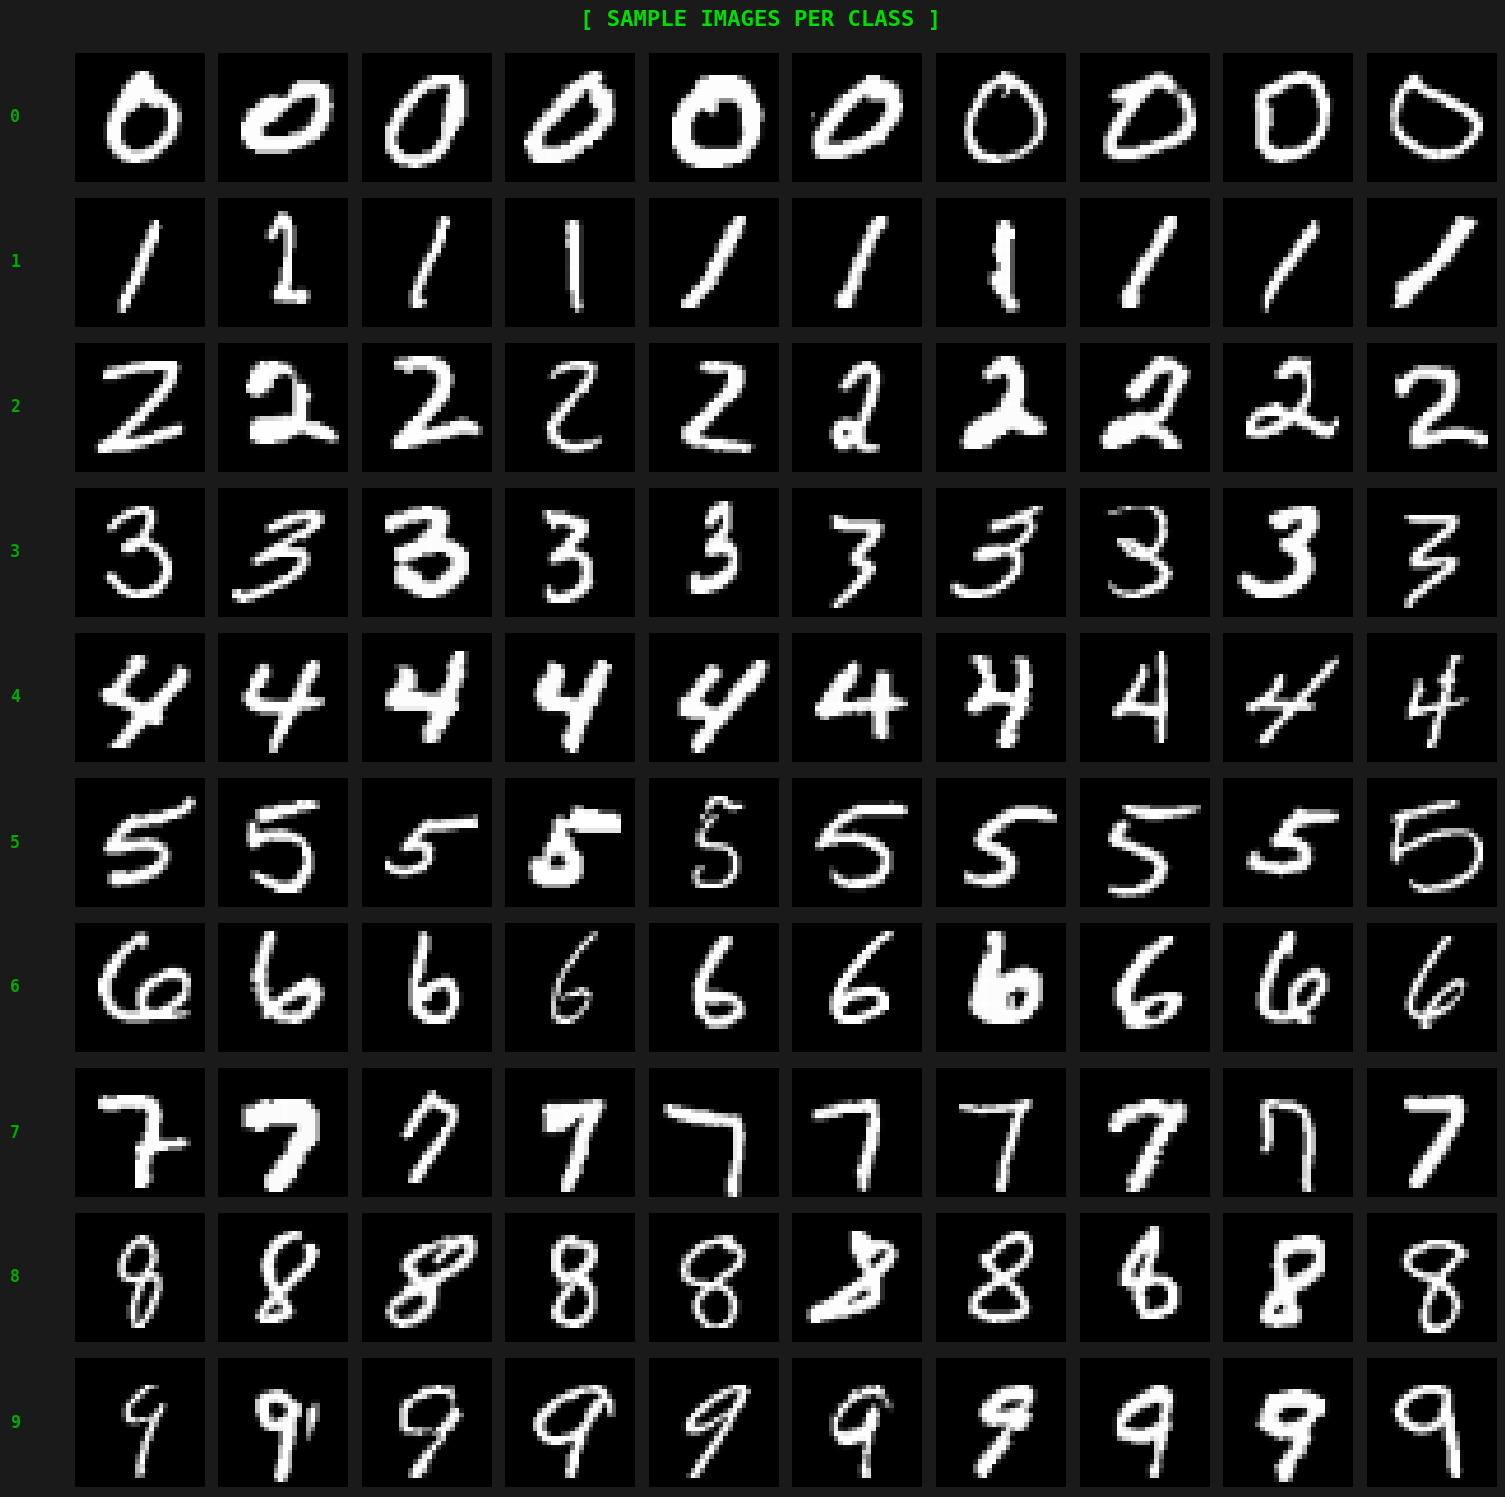

In [14]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('[ SAMPLE IMAGES PER CLASS ]', fontsize=16, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', y=0.995)
fig.patch.set_facecolor(CRT_BG)

for digit in range(10):
    digit_indices = [i for i, (img, label) in enumerate(data) if label == digit]
    random_samples = random.sample(digit_indices, 10)
    
    for idx, sample_idx in enumerate(random_samples):
        img, _ = data[sample_idx]
        ax = axes[digit, idx]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
        
        if idx == 0:
            ax.text(-0.5, 0.5, f'{digit}', transform=ax.transAxes,
                   fontsize=12, color=CRT_GREEN_MEDIUM, weight='bold',
                   fontfamily='monospace', va='center')

plt.tight_layout()
plt.show()

#### mean image heatmaps

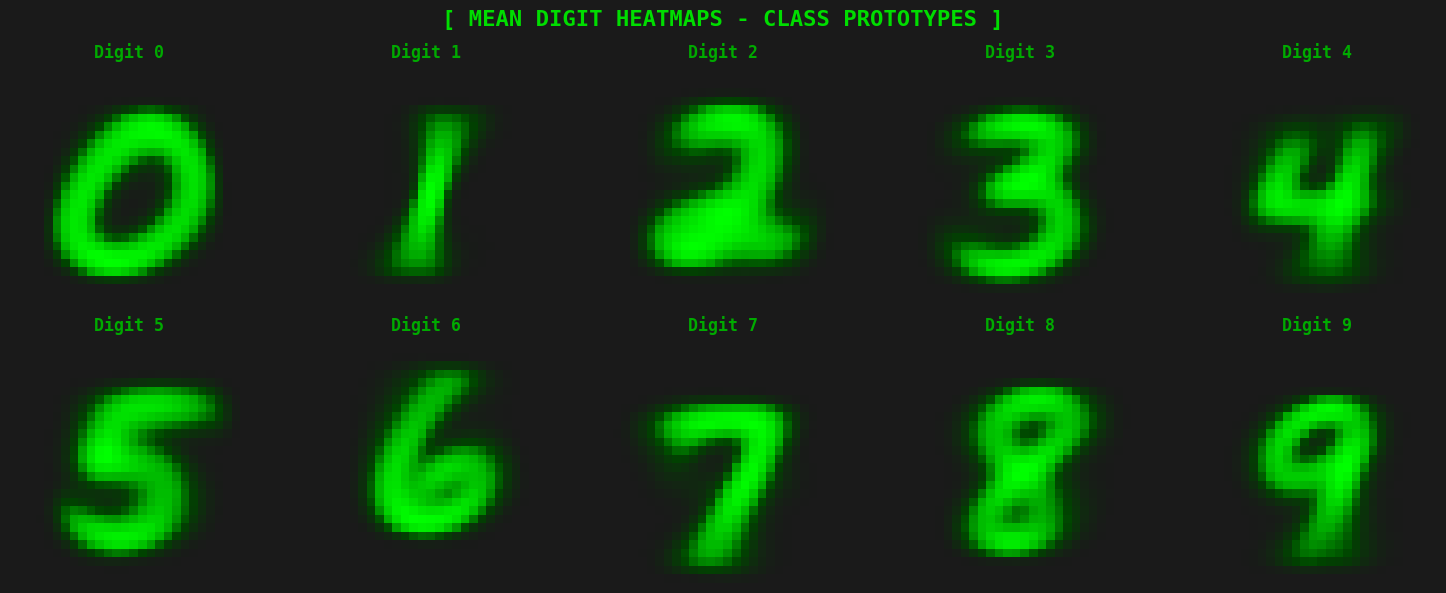

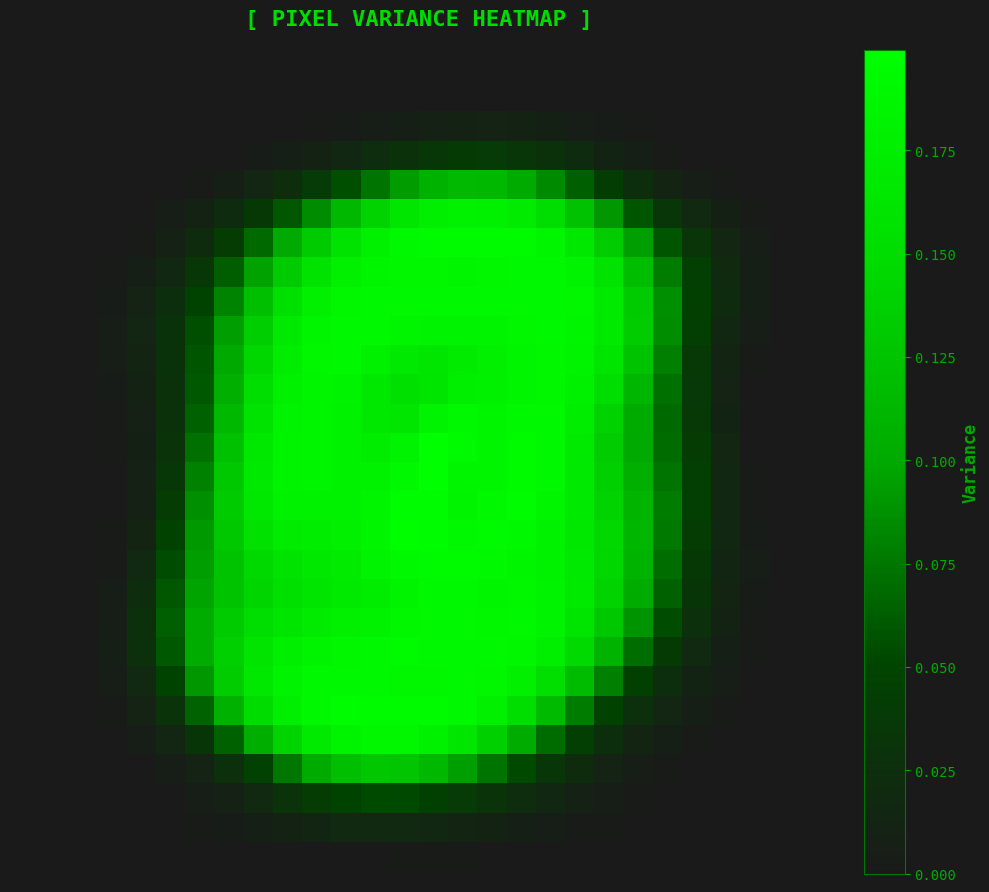

Max variance: 0.1992
Min variance: 0.0000
Mean variance: 0.0673


In [15]:
from matplotlib.colors import LinearSegmentedColormap

green_cmap = LinearSegmentedColormap.from_list(
    'neon_green',
    [CRT_BG, CRT_GREEN_DARK, CRT_GREEN_MEDIUM, CRT_GREEN_BRIGHT, CRT_GREEN_BRIGHTEST]
)

# Single pass through dataset - stack all images once
all_images = torch.stack([img for img, _ in data]).squeeze()

# Compute variance map
variance_map = all_images.var(dim=0)

# Compute mean images per digit
mean_images = []
for digit in range(10):
    digit_indices = [label == digit for _, label in data]
    digit_images = all_images[digit_indices]
    mean_img = digit_images.mean(dim=0)
    mean_images.append(mean_img)

# Plot 1: Mean Digit Heatmaps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('[ MEAN DIGIT HEATMAPS - CLASS PROTOTYPES ]', 
             fontsize=16, color=CRT_GREEN_BRIGHT, fontfamily='monospace', 
             weight='bold', y=0.98)
fig.patch.set_facecolor(CRT_BG)

for idx, (mean_img, ax) in enumerate(zip(mean_images, axes.flatten())):
    im = ax.imshow(mean_img, cmap=green_cmap, interpolation='nearest')
    ax.set_title(f'Digit {idx}', fontsize=12, color=CRT_GREEN_MEDIUM, 
                fontfamily='monospace', weight='bold', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Plot 2: Pixel Variance Heatmap
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor(CRT_BG)
ax.set_facecolor(CRT_BG)

im = ax.imshow(variance_map, cmap=green_cmap, interpolation='nearest')
ax.set_title('[ PIXEL VARIANCE HEATMAP ]', fontsize=16, color=CRT_GREEN_BRIGHT,
            fontfamily='monospace', weight='bold', pad=20)
ax.axis('off')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Variance', fontsize=12, color=CRT_GREEN_MEDIUM, 
              fontfamily='monospace', weight='bold')
cbar.ax.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=10)
cbar.ax.yaxis.label.set_color(CRT_GREEN_MEDIUM)

plt.tight_layout()
plt.show()

print(f"Max variance: {variance_map.max().item():.4f}")
print(f"Min variance: {variance_map.min().item():.4f}")
print(f"Mean variance: {variance_map.mean().item():.4f}")

## data framework & inital model config

In [11]:
train_size = 50000
val_size = 10000
generator = torch.Generator().manual_seed(42)

train_subset, val_subset = random_split(
    data, 
    [train_size, val_size],
    generator=generator
)

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_ds)}")

train_labels_subset = [data[i][1] for i in train_subset.indices]
val_labels_subset = [data[i][1] for i in val_subset.indices]

from collections import Counter
train_dist = Counter(train_labels_subset)
val_dist = Counter(val_labels_subset)

print("\nClass distribution verification:")
print("Train:", {k: f"{v/len(train_subset)*100:.1f}%" for k, v in sorted(train_dist.items())})
print("Val:  ", {k: f"{v/len(val_subset)*100:.1f}%" for k, v in sorted(val_dist.items())})

Training set size: 50000
Validation set size: 10000
Test set size: 10000

Class distribution verification:
Train: {0: '9.8%', 1: '11.2%', 2: '9.9%', 3: '10.2%', 4: '9.7%', 5: '9.1%', 6: '9.9%', 7: '10.4%', 8: '9.8%', 9: '10.0%'}
Val:   {0: '10.0%', 1: '11.3%', 2: '10.0%', 3: '10.4%', 4: '9.8%', 5: '8.8%', 6: '9.8%', 7: '10.6%', 8: '9.7%', 9: '9.6%'}


In [12]:
config = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'num_epochs': 15,
    'hidden_sizes': [64, 32, 16],
    'dropout_rate': 0.25,
    'weight_decay': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 2,
    'pin_memory': True if torch.cuda.is_available() else False
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Training Configuration:
  batch_size: 64
  learning_rate: 0.001
  num_epochs: 15
  hidden_sizes: [64, 32, 16]
  dropout_rate: 0.25
  weight_decay: 0.0001
  device: cuda
  num_workers: 2
  pin_memory: True


## dataloaders

In [13]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data_aug = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform_train
)

test_data_norm = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform_test
)

train_subset_aug, val_subset_aug = random_split(
    train_data_aug,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_subset_aug,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

val_loader = DataLoader(
    val_subset_aug,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

test_loader = DataLoader(
    test_data_norm,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 782
Val batches: 157
Test batches: 157


## model definition, loss & optimiser

In [14]:
class MNISTClassifier(nn.Module):
    def __init__(self, hidden_sizes, dropout_rate=0.25):
        super(MNISTClassifier, self).__init__()
        
        self.flatten = nn.Flatten()
        
        layers = []
        input_size = 784
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, 10))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

model = MNISTClassifier(
    hidden_sizes=config['hidden_sizes'],
    dropout_rate=config['dropout_rate']
).to(config['device'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {model.__class__.__name__}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nArchitecture:\n{model}")

Model: MNISTClassifier
Total parameters: 53,018
Trainable parameters: 53,018

Architecture:
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Initial learning rate: {config['learning_rate']}")
print(f"Weight decay (L2): {config['weight_decay']}")
print(f"LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

Loss function: CrossEntropyLoss
Optimizer: Adam
Initial learning rate: 0.001
Weight decay (L2): 0.0001
LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


## training

In [16]:

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for images, labels in tqdm(loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

print("Ready for training...")
print(f"Device: {config['device']}")
print(f"Epochs: {config['num_epochs']}\n")

Ready for training...
Device: cuda
Epochs: 15



In [17]:
start_time = time.time()
best_val_acc = 0.0

for epoch in range(config['num_epochs']):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{config['num_epochs']}")
    print(f"{'='*60}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, config['device']
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, config['device']
    )
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ New best model saved (Val Acc: {val_acc:.2f}%)")

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"Training completed in {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 225.62it/s]



Train Loss: 0.8404 | Train Acc: 72.67%
Val Loss:   0.3060 | Val Acc:   91.29%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 91.29%)

Epoch 2/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.20it/s]



Train Loss: 0.4698 | Train Acc: 86.54%
Val Loss:   0.2397 | Val Acc:   93.30%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 93.30%)

Epoch 3/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 221.32it/s]



Train Loss: 0.4049 | Train Acc: 88.80%
Val Loss:   0.2197 | Val Acc:   93.96%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 93.96%)

Epoch 4/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 211.05it/s]



Train Loss: 0.3653 | Train Acc: 89.93%
Val Loss:   0.2033 | Val Acc:   94.47%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 94.47%)

Epoch 5/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 218.02it/s]



Train Loss: 0.3432 | Train Acc: 90.75%
Val Loss:   0.1940 | Val Acc:   94.79%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 94.79%)

Epoch 6/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 210.16it/s]



Train Loss: 0.3228 | Train Acc: 91.16%
Val Loss:   0.1866 | Val Acc:   95.13%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 95.13%)

Epoch 7/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 208.69it/s]



Train Loss: 0.3114 | Train Acc: 91.64%
Val Loss:   0.1770 | Val Acc:   95.21%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 95.21%)

Epoch 8/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 214.06it/s]



Train Loss: 0.3017 | Train Acc: 91.75%
Val Loss:   0.1812 | Val Acc:   95.19%
Learning Rate: 0.001000

Epoch 9/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 222.16it/s]



Train Loss: 0.2961 | Train Acc: 91.98%
Val Loss:   0.1682 | Val Acc:   95.44%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 95.44%)

Epoch 10/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 221.16it/s]



Train Loss: 0.2804 | Train Acc: 92.38%
Val Loss:   0.1673 | Val Acc:   95.47%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 95.47%)

Epoch 11/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 218.71it/s]



Train Loss: 0.2815 | Train Acc: 92.31%
Val Loss:   0.1730 | Val Acc:   95.41%
Learning Rate: 0.001000

Epoch 12/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.15it/s]



Train Loss: 0.2785 | Train Acc: 92.45%
Val Loss:   0.1594 | Val Acc:   95.63%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 95.63%)

Epoch 13/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 219.24it/s]



Train Loss: 0.2777 | Train Acc: 92.60%
Val Loss:   0.1506 | Val Acc:   95.99%
Learning Rate: 0.001000
✓ New best model saved (Val Acc: 95.99%)

Epoch 14/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 214.28it/s]



Train Loss: 0.2668 | Train Acc: 92.85%
Val Loss:   0.1593 | Val Acc:   95.54%
Learning Rate: 0.001000

Epoch 15/15


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.71it/s]


Train Loss: 0.2648 | Train Acc: 92.95%
Val Loss:   0.1579 | Val Acc:   95.86%
Learning Rate: 0.001000

Training completed in 1.36 minutes
Best validation accuracy: 95.99%


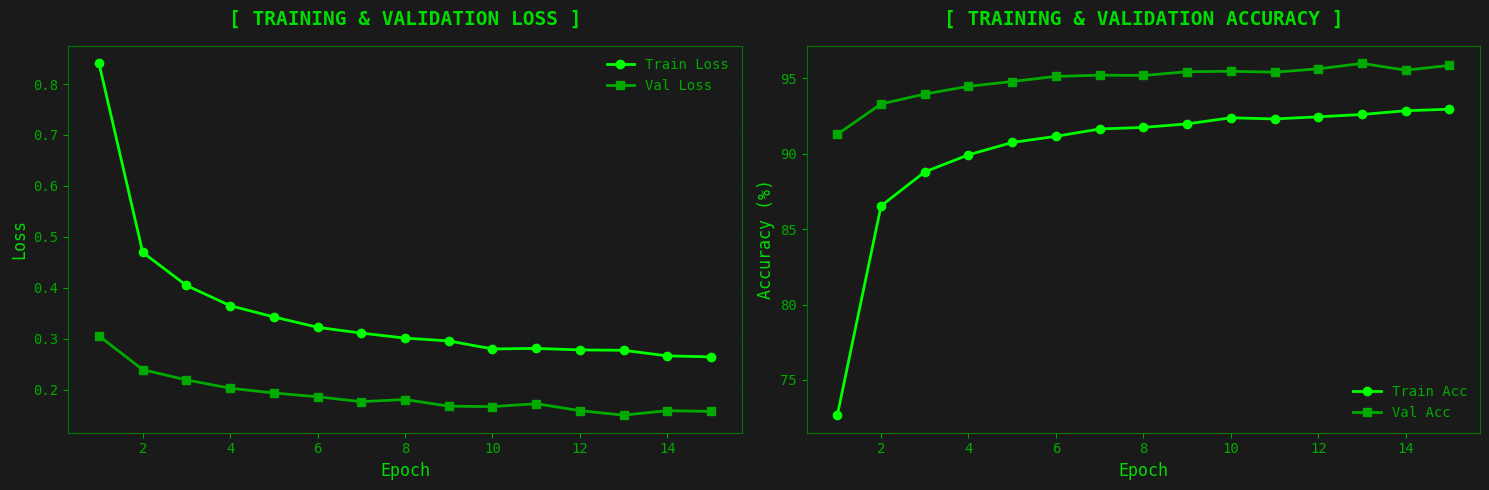

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor(CRT_BG)

epochs = range(1, len(history['train_loss']) + 1)

ax1.set_facecolor(CRT_BG)
ax1.plot(epochs, history['train_loss'], color=CRT_GREEN_BRIGHTEST, 
         linewidth=2, label='Train Loss', marker='o')
ax1.plot(epochs, history['val_loss'], color=CRT_GREEN_MEDIUM, 
         linewidth=2, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch', fontsize=12, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax1.set_ylabel('Loss', fontsize=12, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax1.set_title('[ TRAINING & VALIDATION LOSS ]', fontsize=14, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', pad=15)
ax1.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=10)
ax1.grid(True, linestyle=':', alpha=0.3, color=CRT_GREEN_DARK)
ax1.legend(frameon=False, fontsize=10, labelcolor=CRT_GREEN_MEDIUM)

ax2.set_facecolor(CRT_BG)
ax2.plot(epochs, history['train_acc'], color=CRT_GREEN_BRIGHTEST, 
         linewidth=2, label='Train Acc', marker='o')
ax2.plot(epochs, history['val_acc'], color=CRT_GREEN_MEDIUM, 
         linewidth=2, label='Val Acc', marker='s')
ax2.set_xlabel('Epoch', fontsize=12, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax2.set_ylabel('Accuracy (%)', fontsize=12, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax2.set_title('[ TRAINING & VALIDATION ACCURACY ]', fontsize=14, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', pad=15)
ax2.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=10)
ax2.grid(True, linestyle=':', alpha=0.3, color=CRT_GREEN_DARK)
ax2.legend(frameon=False, fontsize=10, labelcolor=CRT_GREEN_MEDIUM)

plt.tight_layout()
plt.show()

## hyperparameter training

In [23]:
from itertools import product

param_grid = {
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64, 128],
    'hidden_sizes': [[128, 64, 32], [256, 128, 64]],
    'dropout_rate': [0.2, 0.25],
    'weight_decay': [1e-4]
}

all_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['hidden_sizes'],
    param_grid['dropout_rate'],
    param_grid['weight_decay']
))

print(f"Total hyperparameter combinations: {len(all_combinations)}")
print(f"Estimated time: {len(all_combinations) * 1.5:.1f} minutes (if each takes ~1.5 min)")

Total hyperparameter combinations: 24
Estimated time: 36.0 minutes (if each takes ~1.5 min)


In [24]:
results = []
best_overall_acc = 0.0
best_config = None

start_time_total = time.time()

for idx, (lr, bs, hs, dr, wd) in enumerate(all_combinations):
    print(f"\n{'#'*70}")
    print(f"EXPERIMENT {idx+1}/{len(all_combinations)}")
    print(f"{'#'*70}")
    print(f"LR: {lr} | Batch: {bs} | Hidden: {hs} | Dropout: {dr} | WD: {wd}")
    
    train_data_aug_hp = datasets.MNIST(
        root='../data', train=True, download=True,
        transform=transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    
    train_subset_hp, val_subset_hp = random_split(
        train_data_aug_hp, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader_hp = DataLoader(
        train_subset_hp, batch_size=bs, shuffle=True,
        num_workers=config['num_workers'], pin_memory=config['pin_memory']
    )
    
    val_loader_hp = DataLoader(
        val_subset_hp, batch_size=bs, shuffle=False,
        num_workers=config['num_workers'], pin_memory=config['pin_memory']
    )
    
    model_hp = MNISTClassifier(
        hidden_sizes=list(hs), dropout_rate=dr
    ).to(config['device'])
    
    criterion_hp = nn.CrossEntropyLoss()
    optimizer_hp = optim.Adam(
        model_hp.parameters(), lr=lr, weight_decay=wd
    )
    
    scheduler_hp = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_hp, mode='min', factor=0.5, patience=2
    )
    
    best_val_acc_hp = 0.0
    early_stop_counter = 0
    patience = 3
    
    for epoch in range(10):
        train_loss_hp, train_acc_hp = train_epoch(
            model_hp, train_loader_hp, criterion_hp, optimizer_hp, config['device']
        )
        val_loss_hp, val_acc_hp = validate(
            model_hp, val_loader_hp, criterion_hp, config['device']
        )
        
        scheduler_hp.step(val_loss_hp)
        
        if val_acc_hp > best_val_acc_hp:
            best_val_acc_hp = val_acc_hp
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 3 == 0:
            print(f"Epoch {epoch+1}: Val Acc = {val_acc_hp:.2f}%")
    
    results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'hidden_sizes': str(hs),
        'dropout_rate': dr,
        'weight_decay': wd,
        'best_val_acc': best_val_acc_hp,
        'final_train_acc': train_acc_hp,
        'final_val_loss': val_loss_hp
    })
    
    if best_val_acc_hp > best_overall_acc:
        best_overall_acc = best_val_acc_hp
        best_config = {
            'learning_rate': lr,
            'batch_size': bs,
            'hidden_sizes': list(hs),
            'dropout_rate': dr,
            'weight_decay': wd
        }
    
    print(f"Best Val Acc for this config: {best_val_acc_hp:.2f}%")

end_time_total = time.time()
total_minutes = (end_time_total - start_time_total) / 60

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('best_val_acc', ascending=False)

print(f"\n{'='*70}")
print(f"HYPERPARAMETER SEARCH COMPLETED IN {total_minutes:.2f} MINUTES")
print(f"{'='*70}")
print("\nTOP 5 CONFIGURATIONS")
print(f"{'='*70}")
print(results_df.head())

print(f"\n{'='*70}")
print("BEST HYPERPARAMETERS")
print(f"{'='*70}")
for key, value in best_config.items():
    print(f"{key}: {value}")
print(f"Best Validation Accuracy: {best_overall_acc:.2f}%")


######################################################################
EXPERIMENT 1/24
######################################################################
LR: 0.001 | Batch: 32 | Hidden: [128, 64, 32] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 352.06it/s]


Epoch 3: Val Acc = 95.73%


Validating: 100%|██████████| 313/313 [00:01<00:00, 310.07it/s]


Epoch 6: Val Acc = 96.66%


Validating: 100%|██████████| 313/313 [00:00<00:00, 325.18it/s]


Epoch 9: Val Acc = 96.97%


Validating: 100%|██████████| 313/313 [00:00<00:00, 331.10it/s]


Best Val Acc for this config: 96.97%

######################################################################
EXPERIMENT 2/24
######################################################################
LR: 0.001 | Batch: 32 | Hidden: [128, 64, 32] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 324.79it/s]


Epoch 3: Val Acc = 95.55%


Validating: 100%|██████████| 313/313 [00:01<00:00, 276.00it/s]


Epoch 6: Val Acc = 96.46%


Validating: 100%|██████████| 313/313 [00:00<00:00, 341.85it/s]


Epoch 9: Val Acc = 96.59%


Validating: 100%|██████████| 313/313 [00:01<00:00, 307.91it/s]


Early stopping at epoch 10
Best Val Acc for this config: 96.80%

######################################################################
EXPERIMENT 3/24
######################################################################
LR: 0.001 | Batch: 32 | Hidden: [256, 128, 64] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 342.49it/s]


Epoch 3: Val Acc = 96.17%


Validating: 100%|██████████| 313/313 [00:01<00:00, 286.51it/s]


Epoch 6: Val Acc = 96.75%


Validating: 100%|██████████| 313/313 [00:01<00:00, 308.22it/s]


Epoch 9: Val Acc = 96.84%


Validating: 100%|██████████| 313/313 [00:01<00:00, 308.22it/s]


Early stopping at epoch 10
Best Val Acc for this config: 97.26%

######################################################################
EXPERIMENT 4/24
######################################################################
LR: 0.001 | Batch: 32 | Hidden: [256, 128, 64] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 324.82it/s]


Epoch 3: Val Acc = 96.28%


Validating: 100%|██████████| 313/313 [00:01<00:00, 312.70it/s]


Epoch 6: Val Acc = 97.13%


Validating: 100%|██████████| 313/313 [00:01<00:00, 305.26it/s]


Epoch 9: Val Acc = 97.22%


Validating: 100%|██████████| 313/313 [00:00<00:00, 330.51it/s]


Best Val Acc for this config: 97.28%

######################################################################
EXPERIMENT 5/24
######################################################################
LR: 0.001 | Batch: 64 | Hidden: [128, 64, 32] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 195.64it/s]


Epoch 3: Val Acc = 95.47%


Validating: 100%|██████████| 157/157 [00:00<00:00, 218.25it/s]


Epoch 6: Val Acc = 96.83%


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.74it/s]


Early stopping at epoch 8
Best Val Acc for this config: 96.87%

######################################################################
EXPERIMENT 6/24
######################################################################
LR: 0.001 | Batch: 64 | Hidden: [128, 64, 32] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 209.10it/s]


Epoch 3: Val Acc = 95.74%


Validating: 100%|██████████| 157/157 [00:00<00:00, 223.02it/s]


Epoch 6: Val Acc = 96.73%


Validating: 100%|██████████| 157/157 [00:00<00:00, 211.34it/s]


Epoch 9: Val Acc = 97.12%


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.01it/s]


Best Val Acc for this config: 97.12%

######################################################################
EXPERIMENT 7/24
######################################################################
LR: 0.001 | Batch: 64 | Hidden: [256, 128, 64] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 223.74it/s]


Epoch 3: Val Acc = 96.58%


Validating: 100%|██████████| 157/157 [00:00<00:00, 221.84it/s]


Epoch 6: Val Acc = 96.88%


Validating: 100%|██████████| 157/157 [00:00<00:00, 224.17it/s]


Epoch 9: Val Acc = 97.38%


Validating: 100%|██████████| 157/157 [00:00<00:00, 222.95it/s]


Best Val Acc for this config: 97.46%

######################################################################
EXPERIMENT 8/24
######################################################################
LR: 0.001 | Batch: 64 | Hidden: [256, 128, 64] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 197.46it/s]


Epoch 3: Val Acc = 96.57%


Validating: 100%|██████████| 157/157 [00:00<00:00, 221.09it/s]


Epoch 6: Val Acc = 97.12%


Validating: 100%|██████████| 157/157 [00:00<00:00, 213.07it/s]


Epoch 9: Val Acc = 97.31%


Validating: 100%|██████████| 157/157 [00:00<00:00, 219.21it/s]


Best Val Acc for this config: 97.38%

######################################################################
EXPERIMENT 9/24
######################################################################
LR: 0.001 | Batch: 128 | Hidden: [128, 64, 32] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 125.22it/s]


Epoch 3: Val Acc = 95.49%


Validating: 100%|██████████| 79/79 [00:00<00:00, 130.37it/s]


Epoch 6: Val Acc = 96.29%


Validating: 100%|██████████| 79/79 [00:00<00:00, 129.61it/s]


Epoch 9: Val Acc = 96.79%


Validating: 100%|██████████| 79/79 [00:00<00:00, 131.01it/s]


Best Val Acc for this config: 97.00%

######################################################################
EXPERIMENT 10/24
######################################################################
LR: 0.001 | Batch: 128 | Hidden: [128, 64, 32] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 127.01it/s]


Epoch 3: Val Acc = 95.30%


Validating: 100%|██████████| 79/79 [00:00<00:00, 123.34it/s]


Epoch 6: Val Acc = 96.46%


Validating: 100%|██████████| 79/79 [00:00<00:00, 128.69it/s]


Epoch 9: Val Acc = 96.86%


Validating: 100%|██████████| 79/79 [00:00<00:00, 129.51it/s]


Best Val Acc for this config: 96.96%

######################################################################
EXPERIMENT 11/24
######################################################################
LR: 0.001 | Batch: 128 | Hidden: [256, 128, 64] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 123.58it/s]


Epoch 3: Val Acc = 96.38%


Validating: 100%|██████████| 79/79 [00:00<00:00, 125.45it/s]


Epoch 6: Val Acc = 97.13%


Validating: 100%|██████████| 79/79 [00:00<00:00, 125.29it/s]


Epoch 9: Val Acc = 97.46%


Validating: 100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


Best Val Acc for this config: 97.46%

######################################################################
EXPERIMENT 12/24
######################################################################
LR: 0.001 | Batch: 128 | Hidden: [256, 128, 64] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 128.24it/s]


Epoch 3: Val Acc = 96.23%


Validating: 100%|██████████| 79/79 [00:00<00:00, 129.61it/s]


Epoch 6: Val Acc = 97.25%


Validating: 100%|██████████| 79/79 [00:00<00:00, 127.72it/s]


Epoch 9: Val Acc = 97.46%


Validating: 100%|██████████| 79/79 [00:00<00:00, 130.63it/s]


Best Val Acc for this config: 97.46%

######################################################################
EXPERIMENT 13/24
######################################################################
LR: 0.0005 | Batch: 32 | Hidden: [128, 64, 32] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 354.28it/s]


Epoch 3: Val Acc = 95.45%


Validating: 100%|██████████| 313/313 [00:00<00:00, 344.22it/s]


Epoch 6: Val Acc = 96.82%


Validating: 100%|██████████| 313/313 [00:00<00:00, 343.13it/s]


Epoch 9: Val Acc = 97.17%


Validating: 100%|██████████| 313/313 [00:00<00:00, 355.96it/s]


Best Val Acc for this config: 97.17%

######################################################################
EXPERIMENT 14/24
######################################################################
LR: 0.0005 | Batch: 32 | Hidden: [128, 64, 32] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 340.44it/s]


Epoch 3: Val Acc = 95.60%


Validating: 100%|██████████| 313/313 [00:01<00:00, 182.68it/s]


Epoch 6: Val Acc = 96.50%


Validating: 100%|██████████| 313/313 [00:00<00:00, 340.85it/s]


Epoch 9: Val Acc = 96.87%


Validating: 100%|██████████| 313/313 [00:00<00:00, 341.03it/s]


Best Val Acc for this config: 96.99%

######################################################################
EXPERIMENT 15/24
######################################################################
LR: 0.0005 | Batch: 32 | Hidden: [256, 128, 64] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 349.47it/s]


Epoch 3: Val Acc = 96.66%


Validating: 100%|██████████| 313/313 [00:00<00:00, 352.03it/s]


Epoch 6: Val Acc = 97.07%


Validating: 100%|██████████| 313/313 [00:00<00:00, 327.70it/s]


Epoch 9: Val Acc = 97.35%


Validating: 100%|██████████| 313/313 [00:00<00:00, 337.67it/s]


Best Val Acc for this config: 97.54%

######################################################################
EXPERIMENT 16/24
######################################################################
LR: 0.0005 | Batch: 32 | Hidden: [256, 128, 64] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 313/313 [00:00<00:00, 332.75it/s]


Epoch 3: Val Acc = 96.32%


Validating: 100%|██████████| 313/313 [00:00<00:00, 341.64it/s]


Epoch 6: Val Acc = 97.34%


Validating: 100%|██████████| 313/313 [00:00<00:00, 325.61it/s]


Epoch 9: Val Acc = 97.43%


Validating: 100%|██████████| 313/313 [00:00<00:00, 351.14it/s]


Best Val Acc for this config: 97.43%

######################################################################
EXPERIMENT 17/24
######################################################################
LR: 0.0005 | Batch: 64 | Hidden: [128, 64, 32] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 211.69it/s]


Epoch 3: Val Acc = 95.59%


Validating: 100%|██████████| 157/157 [00:00<00:00, 206.74it/s]


Epoch 6: Val Acc = 96.23%


Validating: 100%|██████████| 157/157 [00:00<00:00, 215.42it/s]


Epoch 9: Val Acc = 96.86%


Validating: 100%|██████████| 157/157 [00:00<00:00, 217.54it/s]


Best Val Acc for this config: 96.98%

######################################################################
EXPERIMENT 18/24
######################################################################
LR: 0.0005 | Batch: 64 | Hidden: [128, 64, 32] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 212.72it/s]


Epoch 3: Val Acc = 95.17%


Validating: 100%|██████████| 157/157 [00:00<00:00, 217.63it/s]


Epoch 6: Val Acc = 96.41%


Validating: 100%|██████████| 157/157 [00:00<00:00, 218.53it/s]


Epoch 9: Val Acc = 96.81%


Validating: 100%|██████████| 157/157 [00:00<00:00, 219.00it/s]


Best Val Acc for this config: 96.82%

######################################################################
EXPERIMENT 19/24
######################################################################
LR: 0.0005 | Batch: 64 | Hidden: [256, 128, 64] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:00<00:00, 215.49it/s]


Epoch 3: Val Acc = 96.24%


Validating: 100%|██████████| 157/157 [00:00<00:00, 215.05it/s]


Epoch 6: Val Acc = 97.26%


Validating: 100%|██████████| 157/157 [00:00<00:00, 212.35it/s]


Epoch 9: Val Acc = 97.53%


Validating: 100%|██████████| 157/157 [00:00<00:00, 215.15it/s]


Best Val Acc for this config: 97.53%

######################################################################
EXPERIMENT 20/24
######################################################################
LR: 0.0005 | Batch: 64 | Hidden: [256, 128, 64] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 157/157 [00:01<00:00, 96.51it/s] 


Epoch 3: Val Acc = 96.24%


Validating: 100%|██████████| 157/157 [00:00<00:00, 214.76it/s]


Epoch 6: Val Acc = 96.88%


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.06it/s]


Epoch 9: Val Acc = 97.44%


Validating: 100%|██████████| 157/157 [00:00<00:00, 220.91it/s]


Best Val Acc for this config: 97.44%

######################################################################
EXPERIMENT 21/24
######################################################################
LR: 0.0005 | Batch: 128 | Hidden: [128, 64, 32] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 123.14it/s]


Epoch 3: Val Acc = 94.39%


Validating: 100%|██████████| 79/79 [00:00<00:00, 128.52it/s]


Epoch 6: Val Acc = 96.14%


Validating: 100%|██████████| 79/79 [00:00<00:00, 130.14it/s]


Epoch 9: Val Acc = 96.76%


Validating: 100%|██████████| 79/79 [00:00<00:00, 129.01it/s]


Best Val Acc for this config: 96.76%

######################################################################
EXPERIMENT 22/24
######################################################################
LR: 0.0005 | Batch: 128 | Hidden: [128, 64, 32] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 116.21it/s]


Epoch 3: Val Acc = 94.44%


Validating: 100%|██████████| 79/79 [00:00<00:00, 128.01it/s]


Epoch 6: Val Acc = 95.96%


Validating: 100%|██████████| 79/79 [00:00<00:00, 125.66it/s]


Epoch 9: Val Acc = 96.60%


Validating: 100%|██████████| 79/79 [00:00<00:00, 102.39it/s]


Best Val Acc for this config: 96.73%

######################################################################
EXPERIMENT 23/24
######################################################################
LR: 0.0005 | Batch: 128 | Hidden: [256, 128, 64] | Dropout: 0.2 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 122.17it/s]


Epoch 3: Val Acc = 96.02%


Validating: 100%|██████████| 79/79 [00:00<00:00, 126.32it/s]


Epoch 6: Val Acc = 96.72%


Validating: 100%|██████████| 79/79 [00:00<00:00, 128.85it/s]


Epoch 9: Val Acc = 97.28%


Validating: 100%|██████████| 79/79 [00:00<00:00, 119.88it/s]


Best Val Acc for this config: 97.51%

######################################################################
EXPERIMENT 24/24
######################################################################
LR: 0.0005 | Batch: 128 | Hidden: [256, 128, 64] | Dropout: 0.25 | WD: 0.0001


Validating: 100%|██████████| 79/79 [00:00<00:00, 121.54it/s]


Epoch 3: Val Acc = 95.83%


Validating: 100%|██████████| 79/79 [00:00<00:00, 121.02it/s]


Epoch 6: Val Acc = 97.01%


Validating: 100%|██████████| 79/79 [00:00<00:00, 123.30it/s]


Epoch 9: Val Acc = 97.34%


Validating: 100%|██████████| 79/79 [00:00<00:00, 121.59it/s]

Best Val Acc for this config: 97.35%

HYPERPARAMETER SEARCH COMPLETED IN 26.84 MINUTES

TOP 5 CONFIGURATIONS
    learning_rate  batch_size    hidden_sizes  dropout_rate  weight_decay  \
14         0.0005          32  [256, 128, 64]          0.20        0.0001   
18         0.0005          64  [256, 128, 64]          0.20        0.0001   
22         0.0005         128  [256, 128, 64]          0.20        0.0001   
6          0.0010          64  [256, 128, 64]          0.20        0.0001   
11         0.0010         128  [256, 128, 64]          0.25        0.0001   

    best_val_acc  final_train_acc  final_val_loss  
14         97.54           97.480        0.083567  
18         97.53           97.572        0.086910  
22         97.51           97.444        0.081703  
6          97.46           97.250        0.095383  
11         97.46           97.126        0.084143  

BEST HYPERPARAMETERS
learning_rate: 0.0005
batch_size: 32
hidden_sizes: [256, 128, 64]
dropout_rate: 0.2
weight_dec

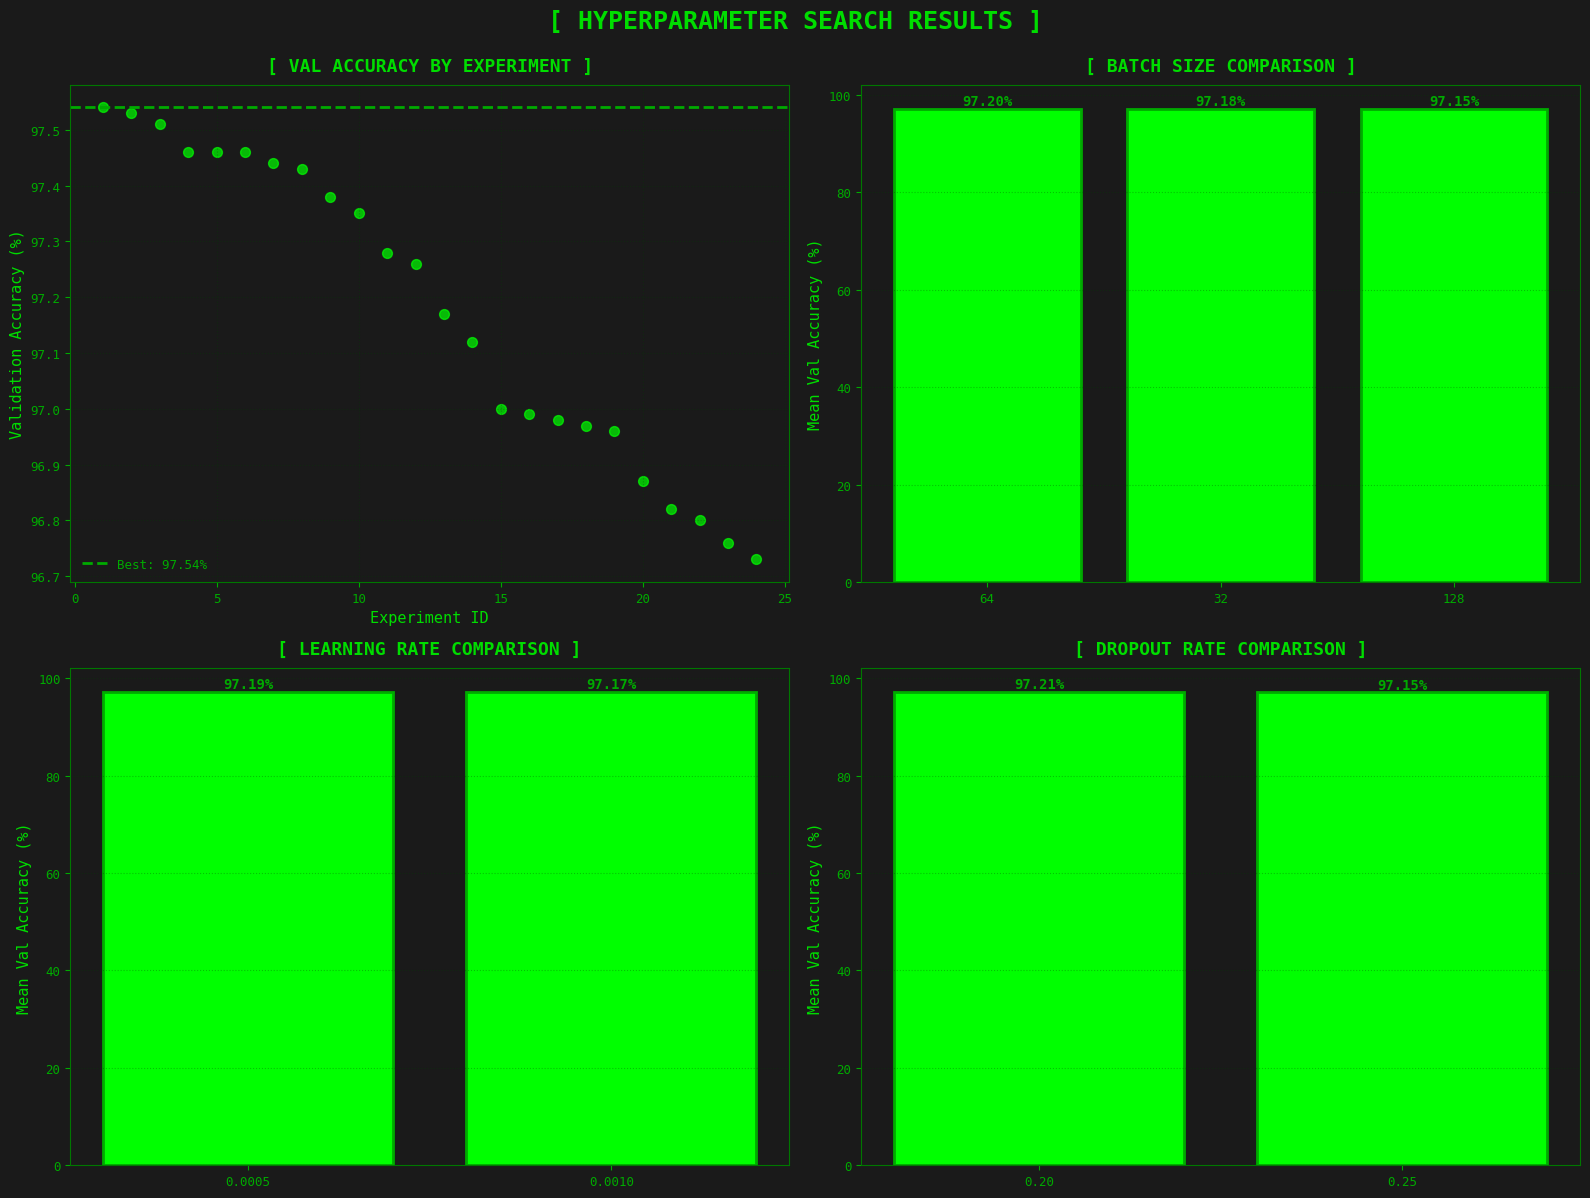


Total experiments: 24
Best accuracy: 97.54%
Worst accuracy: 96.73%
Mean accuracy: 97.18%
Std deviation: 0.28%


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor(CRT_BG)
fig.suptitle('[ HYPERPARAMETER SEARCH RESULTS ]', 
             fontsize=18, color=CRT_GREEN_BRIGHT, fontfamily='monospace', 
             weight='bold', y=0.995)

results_df['experiment_id'] = range(1, len(results_df) + 1)

ax1 = axes[0, 0]
ax1.set_facecolor(CRT_BG)
ax1.scatter(results_df['experiment_id'], results_df['best_val_acc'], 
           color=CRT_GREEN_BRIGHTEST, s=50, alpha=0.7)
ax1.axhline(y=results_df['best_val_acc'].max(), color=CRT_GREEN_MEDIUM, 
           linestyle='--', linewidth=2, label=f"Best: {results_df['best_val_acc'].max():.2f}%")
ax1.set_xlabel('Experiment ID', fontsize=11, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax1.set_ylabel('Validation Accuracy (%)', fontsize=11, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax1.set_title('[ VAL ACCURACY BY EXPERIMENT ]', fontsize=13, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', pad=10)
ax1.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=9)
ax1.grid(True, linestyle=':', alpha=0.3, color=CRT_GREEN_DARK)
ax1.legend(frameon=False, fontsize=9, labelcolor=CRT_GREEN_MEDIUM)

ax2 = axes[0, 1]
ax2.set_facecolor(CRT_BG)
batch_groups = results_df.groupby('batch_size')['best_val_acc'].mean().sort_values(ascending=False)
bars = ax2.bar(range(len(batch_groups)), batch_groups.values, color=CRT_GREEN_BRIGHTEST, edgecolor=CRT_GREEN_MEDIUM, linewidth=2)
ax2.set_xticks(range(len(batch_groups)))
ax2.set_xticklabels([str(int(x)) for x in batch_groups.index], fontsize=10, color=CRT_GREEN_MEDIUM, fontfamily='monospace')
ax2.set_ylabel('Mean Val Accuracy (%)', fontsize=11, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax2.set_title('[ BATCH SIZE COMPARISON ]', fontsize=13, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', pad=10)
ax2.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=9)
ax2.grid(True, linestyle=':', alpha=0.3, color=CRT_GREEN_DARK, axis='y')
for bar, val in zip(bars, batch_groups.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}%', ha='center', va='bottom', 
            fontsize=10, color=CRT_GREEN_MEDIUM, fontfamily='monospace', weight='bold')

ax3 = axes[1, 0]
ax3.set_facecolor(CRT_BG)
lr_groups = results_df.groupby('learning_rate')['best_val_acc'].mean().sort_values(ascending=False)
bars = ax3.bar(range(len(lr_groups)), lr_groups.values, color=CRT_GREEN_BRIGHTEST, edgecolor=CRT_GREEN_MEDIUM, linewidth=2)
ax3.set_xticks(range(len(lr_groups)))
ax3.set_xticklabels([f'{x:.4f}' for x in lr_groups.index], fontsize=10, color=CRT_GREEN_MEDIUM, fontfamily='monospace')
ax3.set_ylabel('Mean Val Accuracy (%)', fontsize=11, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax3.set_title('[ LEARNING RATE COMPARISON ]', fontsize=13, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', pad=10)
ax3.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=9)
ax3.grid(True, linestyle=':', alpha=0.3, color=CRT_GREEN_DARK, axis='y')
for bar, val in zip(bars, lr_groups.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}%', ha='center', va='bottom', 
            fontsize=10, color=CRT_GREEN_MEDIUM, fontfamily='monospace', weight='bold')

ax4 = axes[1, 1]
ax4.set_facecolor(CRT_BG)
dropout_groups = results_df.groupby('dropout_rate')['best_val_acc'].mean().sort_values(ascending=False)
bars = ax4.bar(range(len(dropout_groups)), dropout_groups.values, color=CRT_GREEN_BRIGHTEST, edgecolor=CRT_GREEN_MEDIUM, linewidth=2)
ax4.set_xticks(range(len(dropout_groups)))
ax4.set_xticklabels([f'{x:.2f}' for x in dropout_groups.index], fontsize=10, color=CRT_GREEN_MEDIUM, fontfamily='monospace')
ax4.set_ylabel('Mean Val Accuracy (%)', fontsize=11, color=CRT_GREEN_BRIGHT, fontfamily='monospace')
ax4.set_title('[ DROPOUT RATE COMPARISON ]', fontsize=13, color=CRT_GREEN_BRIGHT, 
             fontfamily='monospace', weight='bold', pad=10)
ax4.tick_params(colors=CRT_GREEN_MEDIUM, labelsize=9)
ax4.grid(True, linestyle=':', alpha=0.3, color=CRT_GREEN_DARK, axis='y')
for bar, val in zip(bars, dropout_groups.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}%', ha='center', va='bottom', 
            fontsize=10, color=CRT_GREEN_MEDIUM, fontfamily='monospace', weight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal experiments: {len(results_df)}")
print(f"Best accuracy: {results_df['best_val_acc'].max():.2f}%")
print(f"Worst accuracy: {results_df['best_val_acc'].min():.2f}%")
print(f"Mean accuracy: {results_df['best_val_acc'].mean():.2f}%")
print(f"Std deviation: {results_df['best_val_acc'].std():.2f}%")

## final model training

In [29]:
print("\n" + "="*70)
print(" TRAINING FINAL MODEL WITH BEST CONFIGURATION")
print("="*70)

best_config = {
    'learning_rate': 0.0005,
    'batch_size': 32,
    'hidden_sizes': [256, 128, 64],
    'dropout_rate': 0.20,
    'weight_decay': 0.0001,
    'num_epochs': 20
}

print(f"\n[ CONFIGURATION ]")
for key, value in best_config.items():
    print(f"  {key}: {value}")

model_final = MNISTClassifier(
    hidden_sizes=best_config['hidden_sizes'],
    dropout_rate=best_config['dropout_rate']
).to(device)

train_loader_final = DataLoader(
    train_subset_aug,  
    batch_size=best_config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader_final = DataLoader(
    val_subset_aug,
    batch_size=best_config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == 'cuda' else False
)

criterion_final = nn.CrossEntropyLoss()
optimizer_final = optim.Adam(
    model_final.parameters(),
    lr=best_config['learning_rate'],
    weight_decay=best_config['weight_decay']
)
scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final,
    mode='min',
    factor=0.5,
    patience=3
)

best_val_acc_final = 0
patience = 5
patience_counter = 0

print(f"\n[ TRAINING PROGRESS ]")
start_time = time.time()

for epoch in range(best_config['num_epochs']):
    train_loss, train_acc = train_epoch(
        model_final, train_loader_final, criterion_final, 
        optimizer_final, device
    )
    
    val_loss, val_acc = validate(
        model_final, val_loader_final, criterion_final, device
    )
    
    scheduler_final.step(val_loss)
    
    print(f"Epoch {epoch+1}: Train {train_acc:.2f}% | Val {val_acc:.2f}%")
    
    if val_acc > best_val_acc_final:
        best_val_acc_final = val_acc
        torch.save(model_final.state_dict(), 'best_model_final.pth')
        patience_counter = 0
        print(f"  → Best saved ({val_acc:.2f}%)")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"\nCompleted in {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc_final:.2f}%")


 TRAINING FINAL MODEL WITH BEST CONFIGURATION

[ CONFIGURATION ]
  learning_rate: 0.0005
  batch_size: 32
  hidden_sizes: [256, 128, 64]
  dropout_rate: 0.2
  weight_decay: 0.0001
  num_epochs: 20

[ TRAINING PROGRESS ]


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validating: 100%|██████████| 313/313 [00:00<00:00, 335.05it/s]


Epoch 1: Train 87.52% | Val 94.01%
  → Best saved (94.01%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 332.09it/s]


Epoch 2: Train 94.50% | Val 96.04%
  → Best saved (96.04%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 321.87it/s]


Epoch 3: Train 95.72% | Val 96.72%
  → Best saved (96.72%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 315.66it/s]


Epoch 4: Train 96.38% | Val 96.94%
  → Best saved (96.94%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 327.80it/s]


Epoch 5: Train 96.60% | Val 97.20%
  → Best saved (97.20%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 329.66it/s]


Epoch 6: Train 96.95% | Val 96.85%


Validating: 100%|██████████| 313/313 [00:00<00:00, 331.96it/s]


Epoch 7: Train 97.09% | Val 97.15%


Validating: 100%|██████████| 313/313 [00:00<00:00, 315.85it/s]


Epoch 8: Train 97.21% | Val 97.20%


Validating: 100%|██████████| 313/313 [00:00<00:00, 326.80it/s]


Epoch 9: Train 97.51% | Val 97.29%
  → Best saved (97.29%)


Validating: 100%|██████████| 313/313 [00:01<00:00, 310.85it/s]


Epoch 10: Train 97.41% | Val 97.40%
  → Best saved (97.40%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 318.03it/s]


Epoch 11: Train 97.62% | Val 97.58%
  → Best saved (97.58%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 323.30it/s]


Epoch 12: Train 97.68% | Val 97.29%


Validating: 100%|██████████| 313/313 [00:01<00:00, 278.32it/s]


Epoch 13: Train 97.75% | Val 97.71%
  → Best saved (97.71%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 325.08it/s]


Epoch 14: Train 97.78% | Val 97.58%


Validating: 100%|██████████| 313/313 [00:00<00:00, 323.88it/s]


Epoch 15: Train 97.82% | Val 97.82%
  → Best saved (97.82%)


Validating: 100%|██████████| 313/313 [00:00<00:00, 324.31it/s]


Epoch 16: Train 97.85% | Val 97.67%


Validating: 100%|██████████| 313/313 [00:00<00:00, 333.66it/s]


Epoch 17: Train 97.91% | Val 97.70%


Validating: 100%|██████████| 313/313 [00:00<00:00, 325.67it/s]


Epoch 18: Train 97.92% | Val 97.86%
  → Best saved (97.86%)


Validating: 100%|██████████| 313/313 [00:01<00:00, 307.32it/s]


Epoch 19: Train 98.08% | Val 97.86%


Validating: 100%|██████████| 313/313 [00:00<00:00, 335.01it/s]

Epoch 20: Train 98.13% | Val 97.81%

Completed in 3.48 minutes
Best validation accuracy: 97.86%
